In [ ]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd '/content/gdrive/MyDrive/temp'
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/temp/' as I
  # created a '/temp/' folder in my google drive for this purpose.
del MOUNT_GOOGLE_DRIVE

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1W6_IjlSb9EZ5zhY8oIBmukQpbcGaB6hg/temp


In [ ]:

import os
if not os.path.exists('/content/gdrive/MyDrive/temp/data'):
  # downloading the data
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip

  # decompressing the data
  from zipfile import ZipFile

  with ZipFile('app_data_reduced.zip','r') as zip:
    zip.extractall()
    print('Data decompressed successfully')

  # removing the .zip file after extraction to clean space
  !rm app_data_reduced.zip

In [ ]:
import numpy as np
# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100


print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)


In [ ]:
print(np.max(X_train))
print(np.max(X_valid))

255
255


In [ ]:
# train set
import tensorflow as tf
if np.max(X_train) == 255:
  X_train = X_train.astype('float32')
  for i in range(0,X_train.shape[0]):
    x = X_train[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_train[i,] = tf.keras.applications.vgg19.preprocess_input(x)

# validation set
if np.max(X_valid) == 255:
  X_valid = X_valid.astype('float32')
  for i in range(0,X_valid.shape[0]):
    x = X_valid[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_valid[i,] = tf.keras.applications.vgg19.preprocess_input(x)

In [ ]:
print(np.max(X_train))
print(np.max(X_valid))

151.061
151.061


In [ ]:
value1,counts_gender = np.unique(M_train[:,0],return_counts = True)

value2,counts_ethnicity = np.unique(M_train[:,1],return_counts = True)

value3,counts_emotion = np.unique(M_train[:,2],return_counts = True)

def age_category(age):
  if age <= 0.2:
    return '0-20'
  elif age <= 0.4:
    return '20-40'
  elif age <= 0.6:
    return '40-60'
  else:
    return '60-100'
age_category = np.vectorize(age_category)
Y_train_cat = age_category(Y_train)
value4,counts_age = np.unique(Y_train_cat,return_counts = True)

weight_vals = 2845/(np.concatenate((counts_gender*2,counts_ethnicity*3,counts_emotion*4,counts_age*4)))
print('Gender categories: ',value1)
print('Caounts in each category: ',counts_gender)
print('Weights for each category: ',weight_vals[0:2])
print('-------------------------------------')
print('Ethnicity categories: ',value2)
print('Caounts in each category: ',counts_ethnicity)
print('Weights for each category: ',weight_vals[2:5])
print('-------------------------------------')
print('Emotion categories: ',value3)
print('Caounts in each category: ',counts_emotion)
print('Weights for each category: ',weight_vals[5:9])
print('-------------------------------------')
print('Age categories: ',value4)
print('Caounts in each category: ',counts_age)
print('Weights for each category: ',weight_vals[9:])

Gender categories:  ['female' 'male']
Caounts in each category:  [1413 1432]
Weights for each category:  [1.00672328 0.99336592]
-------------------------------------
Ethnicity categories:  ['afroamerican' 'asian' 'caucasian']
Caounts in each category:  [  90  314 2441]
Weights for each category:  [10.53703704  3.02016985  0.38850198]
-------------------------------------
Emotion categories:  ['happy' 'neutral' 'other' 'slightlyhappy']
Caounts in each category:  [ 491  968  122 1264]
Weights for each category:  [1.44857434 0.7347624  5.82991803 0.56269778]
-------------------------------------
Age categories:  ['0-20' '20-40' '40-60' '60-100']
Caounts in each category:  [ 539 1680  523  103]
Weights for each category:  [1.31957328 0.4233631  1.35994264 6.90533981]


2234.094586122407
3.3151030432637785
0.5506462351143302
0.7852705047881869
0.73409626996336


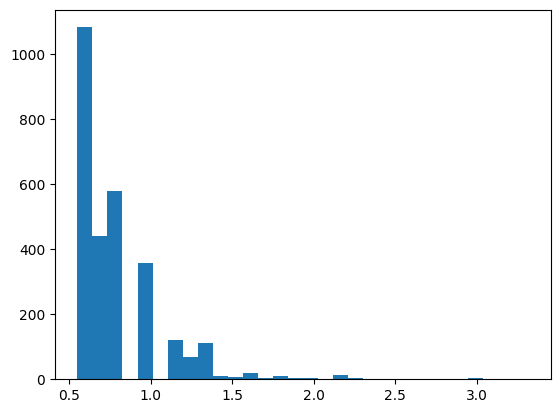

In [ ]:
WEIGHTS_FUNCTION = 5
import matplotlib.pyplot as plt
from scipy.stats import hmean, gmean
def calculate_weights(M_train, gender_weights_dict, ethnicity_weights_dict, emotion_weights_dict, age_weights_dict,WEIGHTS_FUNCTION):
    weights = np.zeros(len(M_train))  # Initialize the weights array

    for i, (gender, ethnicity, emotion) in enumerate(M_train):
        # Look up the corresponding weights for each category
        age_weight = age_weights_dict[age_category(Y_train[i]).item()]
        gender_weight = gender_weights_dict[gender]
        ethnicity_weight = ethnicity_weights_dict[ethnicity]
        emotion_weight = emotion_weights_dict[emotion]

        if WEIGHTS_FUNCTION == 1 or 2 or 3:
          weights[i] =  gender_weight * ethnicity_weight * emotion_weight * age_weight
        if WEIGHTS_FUNCTION == 4:
          weights[i] = np.mean([gender_weight,ethnicity_weight,emotion_weight,age_weight])
        if WEIGHTS_FUNCTION == 5:
          weights[i] = gmean([gender_weight,ethnicity_weight,emotion_weight,age_weight])
        if WEIGHTS_FUNCTION == 6:
          weights[i] = hmean([gender_weight,ethnicity_weight,emotion_weight,age_weight])
        min_weight, max_weight, mean_weight = weights.min(), weights.max(), np.mean(weights)
    if WEIGHTS_FUNCTION == 2:
        weights = (weights-min_weight)*19/(max_weight-min_weight)+1
    if WEIGHTS_FUNCTION == 3:
        weights = np.where(weights <= mean_weight, (weights- min_weight)*9.5/(mean_weight - min_weight), weights)
        weights = np.where(weights > mean_weight, (weights- mean_weight)*9.5/(max_weight - mean_weight) + 9.5, weights) + 1
    return weights

# Create dictionaries mapping category labels to their weights

gender_weights_dict = {'female': weight_vals[0], 'male': weight_vals[1]}
ethnicity_weights_dict = {'afroamerican': weight_vals[2], 'asian': weight_vals[3], 'caucasian': weight_vals[4]}
emotion_weights_dict = {'happy': weight_vals[5], 'neutral': weight_vals[6], 'other': weight_vals[7], 'slightlyhappy': weight_vals[8]}
age_weights_dict = {'0-20': weight_vals[9], '20-40': weight_vals[10], '40-60': weight_vals[11], '60-100': weight_vals[12]}
# Calculate weights for the M_train data
weights_vector = calculate_weights(M_train, gender_weights_dict, ethnicity_weights_dict, emotion_weights_dict,age_weights_dict,WEIGHTS_FUNCTION)
print(sum(weights_vector))
plt.hist(weights_vector,bins = 30)
print(np.max(weights_vector))
print(np.min(weights_vector))
print(np.mean(weights_vector))
print(np.median(weights_vector))
weights_vector = tf.constant(weights_vector, dtype=tf.float32)

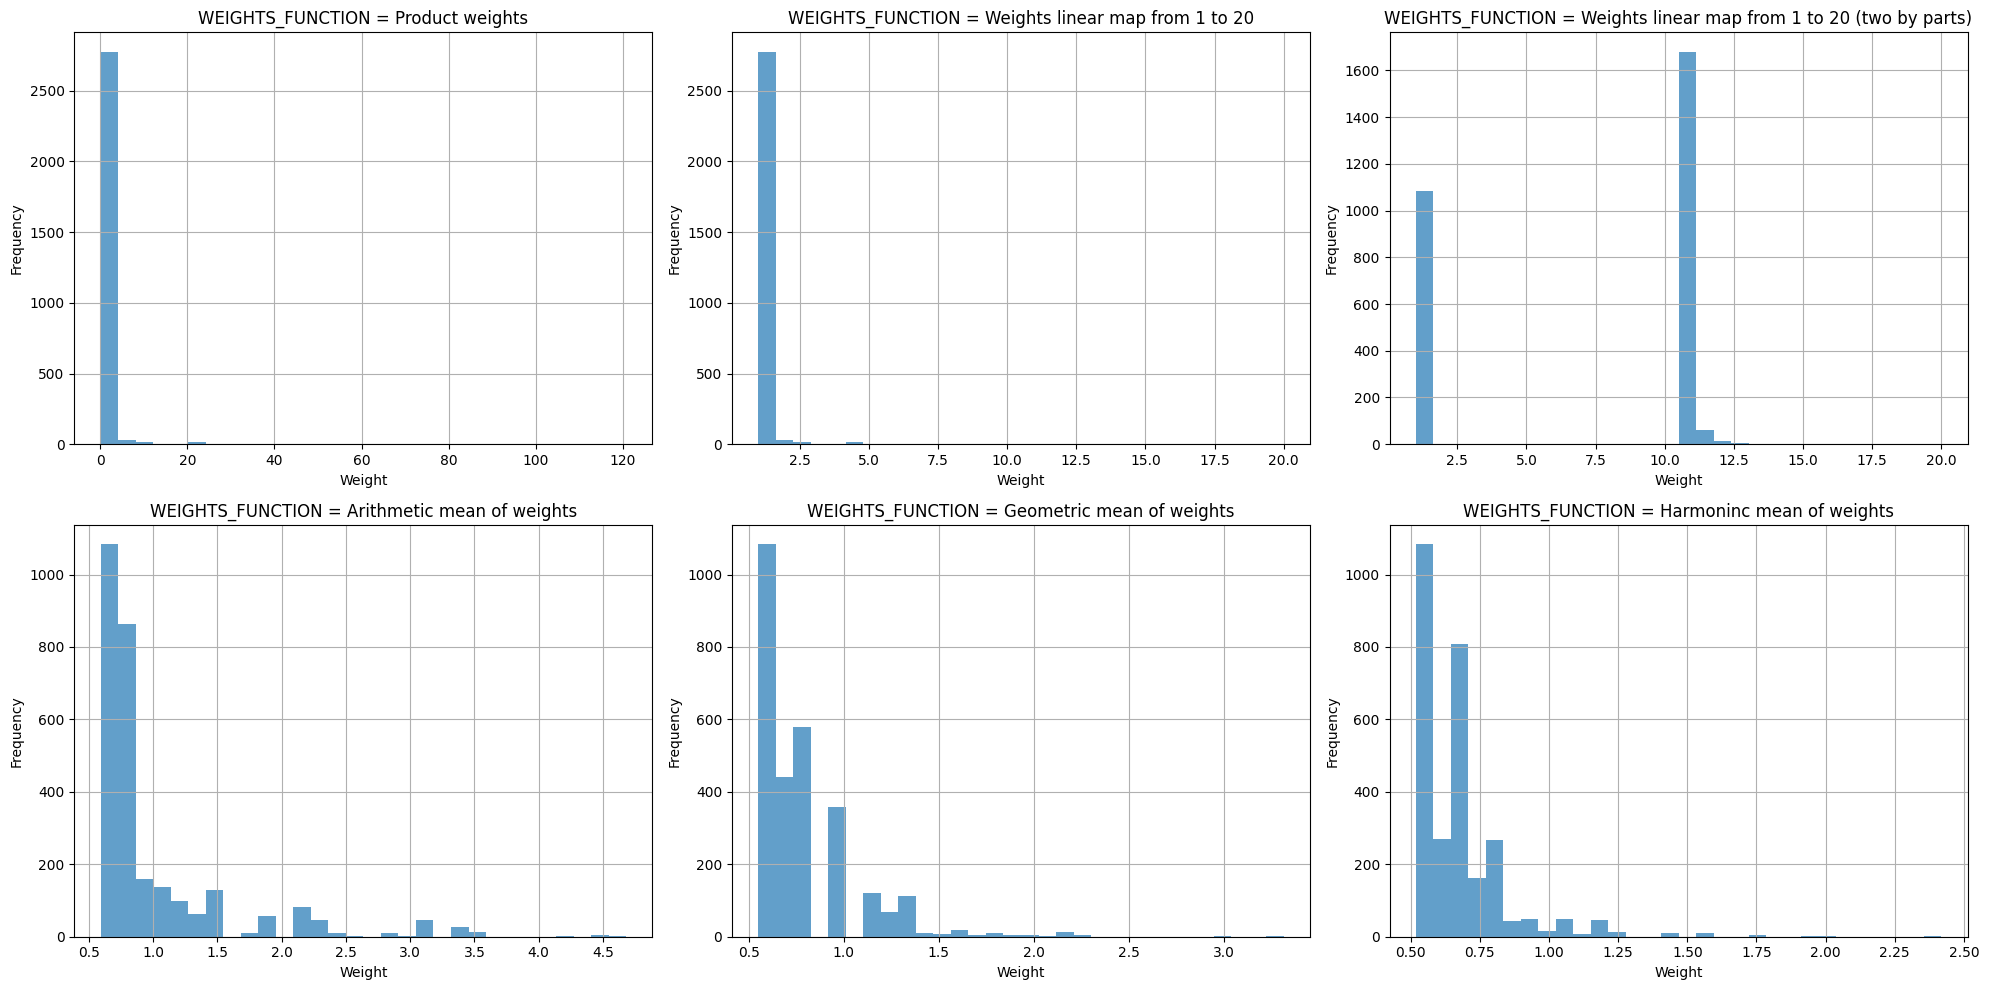

In [ ]:
PLOT_WEIGHTS = True
weights_fun_dict = {1: "Product weights", 2: 'Weights linear map from 1 to 20', 3: 'Weights linear map from 1 to 20 (two by parts)', 4: 'Arithmetic mean of weights', 5: 'Geometric mean of weights', 6: 'Harmoninc mean of weights'}
if PLOT_WEIGHTS == True:
  import matplotlib.pyplot as plt
  fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # Create a 2x3 grid of subplots
  axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

  for i, weights_function in enumerate(range(1, 7)):  # 1 to 6 inclusive
      weights_vector_plot = calculate_weights(M_train, gender_weights_dict, ethnicity_weights_dict, emotion_weights_dict, age_weights_dict, weights_function)

      # Plot the histogram in the ith subplot
      ax = axes[i]
      ax.hist(weights_vector_plot, bins=30, alpha=0.7)
      ax.set_title(f'WEIGHTS_FUNCTION = {weights_fun_dict[i+1]}')
      ax.set_xlabel('Weight')
      ax.set_ylabel('Frequency')
      ax.grid(True)

  plt.tight_layout()  # Adjust layout to prevent overlap
  plt.show()

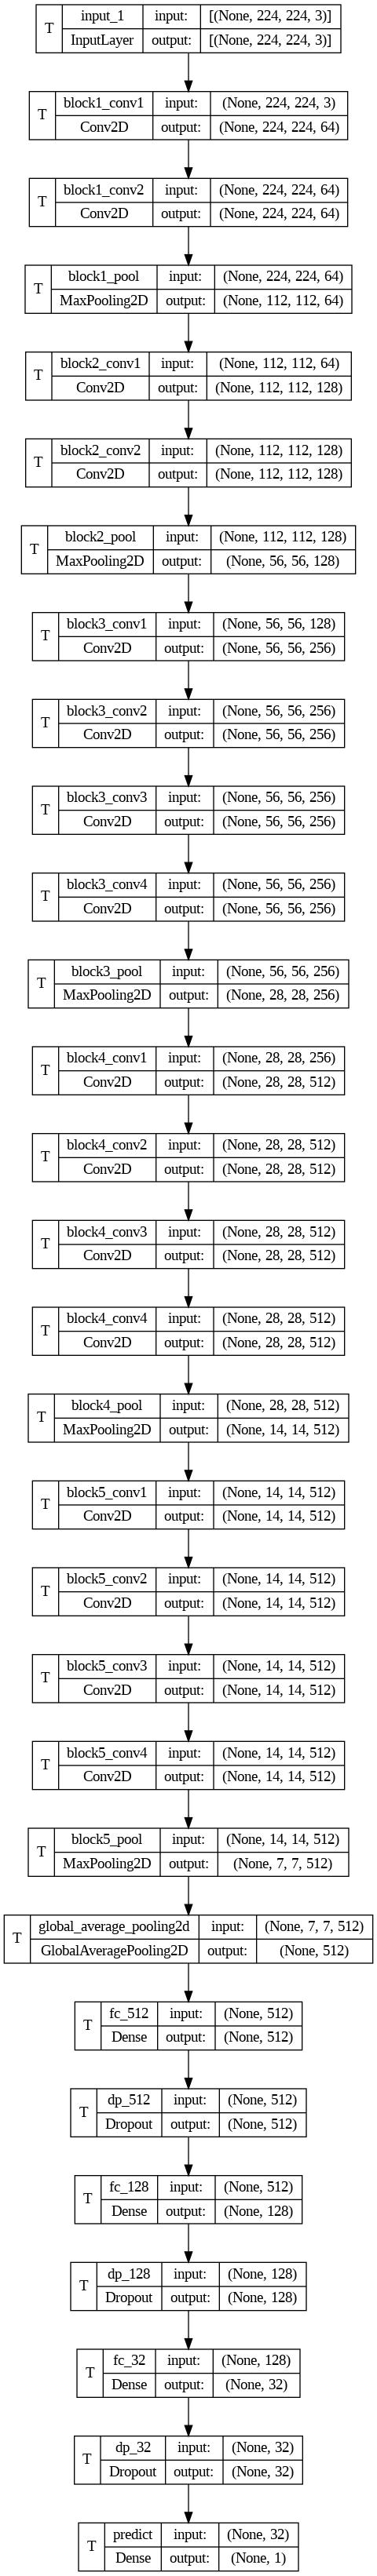

In [ ]:
import pickle

#--------------------------
NUM_EPOCHS = 30
#--------------------------
RESUME_TRAINING = False
RESUME_FROM_EPOCH = 9
#--------------------------



# loading the saved model (best model learned at stage 1)
if(RESUME_TRAINING == False):
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5') # load model from stage 1
else:
  # resume training (stage 2)
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

# setting all layers to traineble
model.trainable = True
tf.keras.utils.plot_model(model, show_shapes=True,show_trainable=True)

In [ ]:
import pickle

#--------------------------
NUM_EPOCHS = 30
#--------------------------
RESUME_TRAINING = False
RESUME_FROM_EPOCH = 9
#--------------------------



# loading the saved model (best model learned at stage 1)
if(RESUME_TRAINING == False):
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5') # load model from stage 1
else:
  # resume training (stage 2)
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

# setting all layers to traineble
model.trainable = True

#=================================================
# training all layers (2nd stage), given the model saved on stage 1
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss='mean_absolute_error',metrics=['mae'])
#=================================================

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10)
mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5', monitor='val_mae', mode='min', save_best_only=True)

if(RESUME_TRAINING == False):
  history = model.fit(X_train, Y_train,  sample_weight=weights_vector,validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage_weighted.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
  history = model.fit(X_train, Y_train, sample_weight=weights_vector,validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=RESUME_FROM_EPOCH, shuffle=True, verbose=1, callbacks=[es,mc])
  # in this code, the training history is not saved if you resume training


Epoch 1/30
178/178 [==============================] - ETA: 0s - loss: 0.0751 - mae: 0.0849

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 86s 362ms/step - loss: 0.0751 - mae: 0.0849 - val_loss: 0.0790 - val_mae: 0.0744
Epoch 2/30
178/178 [==============================] - 56s 317ms/step - loss: 0.0608 - mae: 0.0688 - val_loss: 0.0782 - val_mae: 0.0736
Epoch 3/30
178/178 [==============================] - 70s 396ms/step - loss: 0.0547 - mae: 0.0620 - val_loss: 0.0683 - val_mae: 0.0638
Epoch 4/30
178/178 [==============================] - 58s 324ms/step - loss: 0.0490 - mae: 0.0554 - val_loss: 0.0699 - val_mae: 0.0654
Epoch 5/30
178/178 [==============================] - 56s 316ms/step - loss: 0.0463 - mae: 0.0522 - val_loss: 0.0701 - val_mae: 0.0656
Epoch 6/30
178/178 [==============================] - 57s 318ms/step - loss: 0.0443 - mae: 0.0495 - val_loss: 0.0686 - val_mae: 0.0641
Epoch 7/30
178/178 [==============================] - 64s 359ms/step - loss: 0.0441 - mae: 0.0503 - val_loss: 0.0681 - val_mae: 0.0636
Epoch 8/30
178/178 [==============================] - 67s 379ms/st

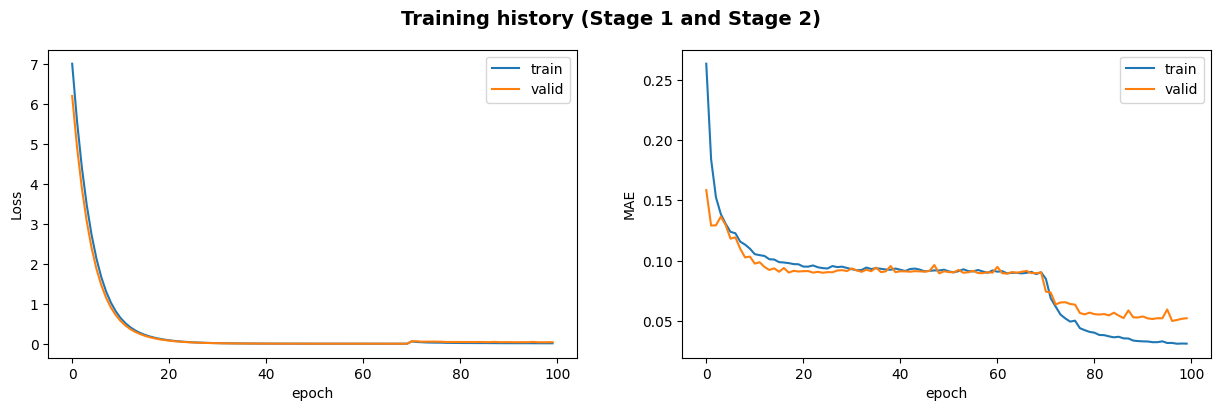

In [ ]:
from matplotlib import pyplot as plt
import pickle

train_hist_2nd = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_2nd_stage_weighted.pkl","rb"))
train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

In [ ]:
# loading the saved models

model_st2_augm = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5')
model_st2_weighted = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

# predict on the VALIDATION data and re-scaling the output predictions (from [0,1] to age range)
predictions_st2_augmented = model_st2_augm.predict(X_valid, batch_size=32, verbose=1)*100
predictions_st2_weighted = model_st2_weighted.predict(X_valid, batch_size=32, verbose=1)*100

33/33 [==============================] - 5s 139ms/step


In [ ]:
# evaluating on validation data
error = []
for i in range(0,len(Y_valid)):
  error.append(abs(np.subtract(predictions_st2_weighted[i][0],Y_valid[i]*100)))

print('MAE (validation set - with custom loss) = %.8f' %(np.mean(error)))


MAE (validation set - with custom loss) = 5.00915588


In [ ]:
# importing the functions used to evaluate the different biases
import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

age_bias(predictions_st2_augmented,Y_valid*100)
age_bias(predictions_st2_weighted,Y_valid*100)

gender_bias(predictions_st2_augmented,Y_valid*100,M_valid)
gender_bias(predictions_st2_weighted,Y_valid*100,M_valid)

ethnicity_bias(predictions_st2_augmented,Y_valid*100,M_valid)
ethnicity_bias(predictions_st2_weighted,Y_valid*100,M_valid)

face_expression_bias(predictions_st2_augmented,Y_valid*100,M_valid)
face_expression_bias(predictions_st2_weighted,Y_valid*100,M_valid)

Age analysis:
Size group 1 = 205, MAE = 4.930331
Size group 2 = 590, MAE = 4.015570
Size group 3 = 197, MAE = 6.392460
Size group 4 = 45, MAE = 8.632846
---------
Age bias (Ba) =  2.552325884501139
Age analysis:
Size group 1 = 205, MAE = 5.320121
Size group 2 = 590, MAE = 4.356706
Size group 3 = 197, MAE = 6.007197
Size group 4 = 45, MAE = 7.777672
---------
Age bias (Ba) =  1.824995517730713
Gender analysis:
Size group female = 497, MAE = 4.849021
Size group male = 540, MAE = 4.847655
---------
Gender bias (Bg) =  0.0013661385
Gender analysis:
Size group female = 497, MAE = 4.941666
Size group male = 540, MAE = 5.071271
---------
Gender bias (Bg) =  0.12960482
Ethnicity Analysis:
Size group asian = 79, MAE = 4.626415
Size group afroamerican = 32, MAE = 4.492286
Size group caucasian = 926, MAE = 4.879543
---------
Ethnicity bias (Be) =  0.2581717173258464
Ethnicity Analysis:
Size group asian = 79, MAE = 4.584430
Size group afroamerican = 32, MAE = 4.484872
Size group caucasian = 926, M

We modify the weights in terms of the different mae values to balance them

In [ ]:
import numpy as np
#
# these are some functions we will use to measure some bias scores
#


#------------------
# age bias
#--------------------
def age_error(predictions, gt):
  error_g1 = []
  error_g2 = []
  error_g3 = []
  error_g4 = []
  for i in range(0,len(gt)):
    if(gt[i]<20):
      error_g1.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=20 and gt[i]<40):
      error_g2.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=40 and gt[i]<60):
      error_g3.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=60):
      error_g4.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Age analysis:')
  print('Size group 1 = %d, MAE = %f' %(len(error_g1), np.mean(error_g1)))
  print('Size group 2 = %d, MAE = %f' %(len(error_g2), np.mean(error_g2)))
  print('Size group 3 = %d, MAE = %f' %(len(error_g3), np.mean(error_g3)))
  print('Size group 4 = %d, MAE = %f' %(len(error_g4), np.mean(error_g4)))
  return np.mean(error_g1),np.mean(error_g2),np.mean(error_g3),np.mean(error_g4)

#------------------
# gender bias
#--------------------
def gender_error(predictions, gt, metadata):
  error_m = []
  error_f = []
  for i in range(0,len(gt)):
    if(metadata[i][0] == 'female'):
      error_f.append(abs(predictions[i]-gt[i]))
    else:
      error_m.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Gender analysis:')
  print('Size group female = %d, MAE = %f' %(len(error_f), np.mean(error_f)))
  print('Size group male = %d, MAE = %f' %(len(error_m), np.mean(error_m)))

  return np.mean(error_f),np.mean(error_m)



#------------------
# ethnicity bias
#--------------------
def ethnicity_error(predictions, gt, metadata):
  error_as = []
  error_af = []
  error_ca = []
  for i in range(0,len(gt)):
    if(metadata[i][1] == 'asian'):
      error_as.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'afroamerican'):
      error_af.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'caucasian'):
      error_ca.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Ethnicity Analysis:')
  print('Size group asian = %d, MAE = %f' %(len(error_as), np.mean(error_as)))
  print('Size group afroamerican = %d, MAE = %f' %(len(error_af), np.mean(error_af)))
  print('Size group caucasian = %d, MAE = %f' %(len(error_ca), np.mean(error_ca)))
  return np.mean(error_as),np.mean(error_af),np.mean(error_ca)

#------------------
# face expression bias
#--------------------
def face_expression_error(predictions, gt, metadata):
  error_h = []
  error_s = []
  error_n = []
  error_o = []
  for i in range(0,len(gt)):
    if(metadata[i][2]=='happy'):
      error_h.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='slightlyhappy'):
      error_s.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='neutral'):
      error_n.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='other'):
      error_o.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Face experession Analysis:')
  print('Size group happy = %d, MAE = %f' %(len(error_h), np.mean(error_h)))
  print('Size group slightlyhappy = %d, MAE = %f' %(len(error_s), np.mean(error_s)))
  print('Size group neutral = %d, MAE = %f' %(len(error_n), np.mean(error_n)))
  print('Size group other = %d, MAE = %f' %(len(error_o), np.mean(error_o)))
  return np.mean(error_h),np.mean(error_s),np.mean(error_n),np.mean(error_o)


In [ ]:
vec_age_error = age_error(predictions_st2_weighted,Y_valid*100)
age_mod = (vec_age_error-np.mean(vec_age_error))/np.mean(vec_age_error)
print(age_mod)
vec_gender_error = gender_error(predictions_st2_weighted,Y_valid*100,M_valid)
gender_mod = (vec_gender_error-np.mean(vec_gender_error))/np.mean(vec_gender_error)
print(gender_mod)
vec_ethnicity_error = ethnicity_error(predictions_st2_weighted,Y_valid*100,M_valid)
ethnicity_mod = (vec_ethnicity_error-np.mean(vec_ethnicity_error))/np.mean(vec_ethnicity_error)
print(ethnicity_mod)
vec_face_expression_error = face_expression_error(predictions_st2_weighted,Y_valid*100,M_valid)
face_expression_mod = (vec_face_expression_error-np.mean(vec_face_expression_error))/np.mean(vec_face_expression_error)
print(face_expression_mod)

Age analysis:
Size group 1 = 205, MAE = 5.320121
Size group 2 = 590, MAE = 4.356706
Size group 3 = 197, MAE = 6.007197
Size group 4 = 45, MAE = 7.777672
[-0.09296913 -0.25722232  0.02417101  0.32602036]
Gender analysis:
Size group female = 497, MAE = 4.941666
Size group male = 540, MAE = 5.071271
[-0.01294378  0.01294369]
Ethnicity Analysis:
Size group asian = 79, MAE = 4.584430
Size group afroamerican = 32, MAE = 4.484872
Size group caucasian = 926, MAE = 5.063508
[-0.02685385 -0.0479872   0.07484096]
Face experession Analysis:
Size group happy = 298, MAE = 5.190681
Size group slightlyhappy = 311, MAE = 4.774614
Size group neutral = 351, MAE = 4.921467
Size group other = 77, MAE = 5.653662
[ 0.01082245 -0.07020142 -0.04160367  0.10098246]


In [ ]:
weights_vector = np.array(weights_vector)
print(np.min(weights_vector))
print(np.max(weights_vector))
for i in range(len(Y_train)):
  weight = weights_vector[i]
  if Y_train_cat[i] == '0-20':
    weights_vector[i] = weight*age_mod[0]+weights_vector[i]
  if Y_train_cat[i] == '20-40':
    weights_vector[i] = weight*age_mod[1]+weights_vector[i]
  if Y_train_cat[i] == '40-60':
    weights_vector[i] = weight*age_mod[2]+weights_vector[i]
  if Y_train_cat[i] == '60-100':
    weights_vector[i] = weight*age_mod[3]+weights_vector[i]
  if M_train[i][0] == 'female':
    weights_vector[i] = weight*gender_mod[0]+weights_vector[i]
  if M_train[i][0] == 'male':
    weights_vector[i] = weight*gender_mod[1]+weights_vector[i]
  if M_train[i][1] == 'asian':
    weights_vector[i] = weight*ethnicity_mod[0]+weights_vector[i]
  if M_train[i][1] == 'afroamerican':
    weights_vector[i] = weight*ethnicity_mod[1]+weights_vector[i]
  if M_train[i][1] == 'caucasian':
    weights_vector[i] = weight*ethnicity_mod[2]+weights_vector[i]
  if M_train[i][2] == 'happy':
    weights_vector[i] = weight*face_expression_mod[0]+weights_vector[i]
  if M_train[i][2] == 'slightlyhappy':
    weights_vector[i] = weight*face_expression_mod[1]+weights_vector[i]
  if M_train[i][2] == 'neutral':
    weights_vector[i] = weight*face_expression_mod[2]+weights_vector[i]
  if M_train[i][2] == 'other':
    weights_vector[i] = weight*face_expression_mod[3]+weights_vector[i]
print(np.min(weights_vector))
print(np.max(weights_vector))

0.55064625
3.315103
0.40578777
4.684548


In [ ]:
import pickle


model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

# setting all layers to trainable
model.trainable = True

#=================================================
# training all layers (2nd stage), given the model saved on stage 1
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-7),loss='mean_absolute_error',metrics=['mae'])
#=================================================

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted_mod.h5', monitor='val_mae', mode='min', save_best_only=True)

history = model.fit(X_train, Y_train,  sample_weight=weights_vector,validation_data=(X_valid, Y_valid), batch_size=16, epochs=20, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
# saving training history
with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage_weighted_mod.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)



Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 0.0248 - mae: 0.0291

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 84s 361ms/step - loss: 0.0248 - mae: 0.0291 - val_loss: 0.0535 - val_mae: 0.0499
Epoch 2/20
178/178 [==============================] - 53s 300ms/step - loss: 0.0246 - mae: 0.0289 - val_loss: 0.0538 - val_mae: 0.0502
Epoch 3/20
178/178 [==============================] - 64s 358ms/step - loss: 0.0247 - mae: 0.0284 - val_loss: 0.0535 - val_mae: 0.0499
Epoch 4/20
178/178 [==============================] - 54s 302ms/step - loss: 0.0241 - mae: 0.0280 - val_loss: 0.0535 - val_mae: 0.0499
Epoch 5/20
178/178 [==============================] - 53s 296ms/step - loss: 0.0241 - mae: 0.0282 - val_loss: 0.0535 - val_mae: 0.0499
Epoch 6/20
178/178 [==============================] - 53s 300ms/step - loss: 0.0237 - mae: 0.0276 - val_loss: 0.0535 - val_mae: 0.0500
Epoch 7/20
178/178 [==============================] - 60s 335ms/step - loss: 0.0244 - mae: 0.0282 - val_loss: 0.0533 - val_mae: 0.0497
Epoch 8/20
178/178 [==============================] - 59s 332ms/st

In [ ]:
model_st2_weighted_mod = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted_mod.h5')
predictions_st2_weighted_mod = model_st2_weighted_mod.predict(X_valid, batch_size=32, verbose=1)*100
# evaluating on validation data
error = []
for i in range(0,len(Y_valid)):
  error.append(abs(np.subtract(predictions_st2_weighted_mod[i][0],Y_valid[i]*100)))
print('MAE (validation set - with custom loss) = %.8f' %(np.mean(error)))
# importing the functions used to evaluate the different biases
import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

age_bias(predictions_st2_weighted_mod,Y_valid*100)

gender_bias(predictions_st2_weighted_mod,Y_valid*100,M_valid)

ethnicity_bias(predictions_st2_weighted_mod,Y_valid*100,M_valid)

face_expression_bias(predictions_st2_weighted_mod,Y_valid*100,M_valid)


33/33 [==============================] - 5s 162ms/step
MAE (validation set - with custom loss) = 4.95230563
Age analysis:
Size group 1 = 205, MAE = 5.462020
Size group 2 = 590, MAE = 3.985684
Size group 3 = 197, MAE = 6.382633
Size group 4 = 45, MAE = 9.042097
---------
Age bias (Ba) =  2.6816418965657554
Gender analysis:
Size group female = 497, MAE = 4.956485
Size group male = 540, MAE = 4.948459
---------
Gender bias (Bg) =  0.008025646
Ethnicity Analysis:
Size group asian = 79, MAE = 4.424350
Size group afroamerican = 32, MAE = 4.462228
Size group caucasian = 926, MAE = 5.014283
---------
Ethnicity bias (Be) =  0.39328861236572266
Face experession Analysis:
Size group happy = 298, MAE = 5.075971
Size group slightlyhappy = 311, MAE = 4.710270
Size group neutral = 351, MAE = 4.921558
Size group other = 77, MAE = 5.591436
---------
Face Expression bias (Bf) =  0.46631820996602374


## Train Starting kit with imagenet

Train Starting kit with imagenet.

In [ ]:
import numpy as np
# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100


print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)


In [ ]:
import tensorflow as tf
# train set
X_train = X_train.astype('float32')
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

# validation set
X_valid = X_valid.astype('float32')
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = tf.keras.applications.resnet50.preprocess_input(x)

In [ ]:
print(np.max(X_valid))

151.061


94765736/94765736 [==============================] - 0s 0us/step


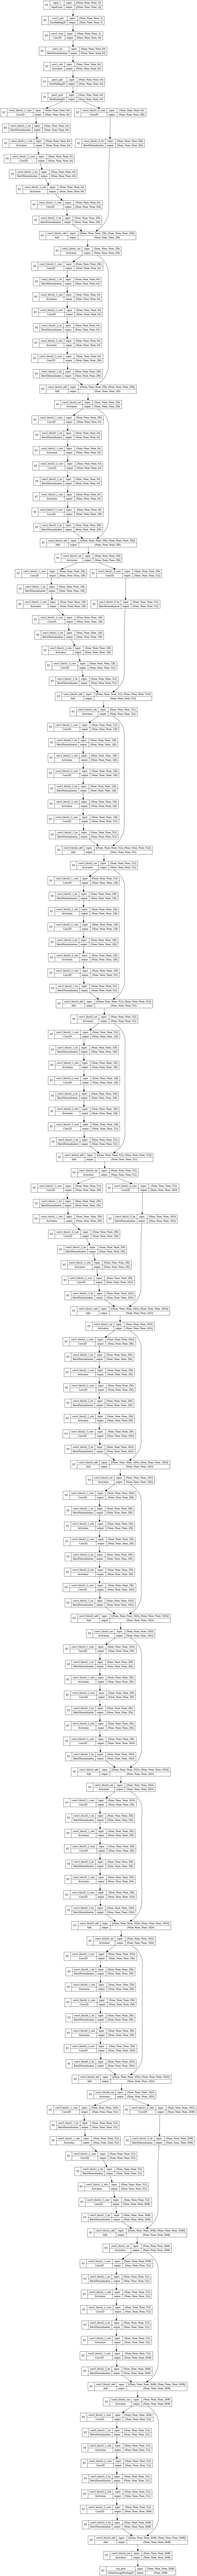

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Attention
from tensorflow.keras import regularizers
base_model = ResNet50(weights='imagenet',pooling = 'avg',include_top = False)
# Freeze all layers in the base model
base_model.trainable = False

# Visualize the model
tf.keras.utils.plot_model(base_model, show_shapes=True,show_trainable=True)

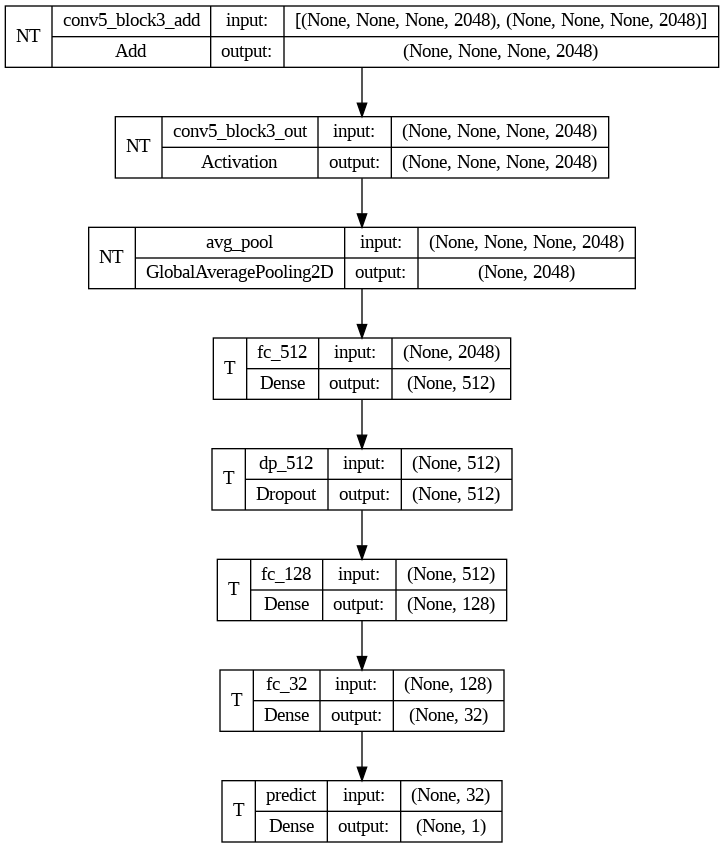

In [ ]:
import tensorflow as tf

fc_2048 = base_model.get_layer(base_model.layers[-1].name).output

fc_512 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc_512')(fc_2048)
dp_layer_512 = tf.keras.layers.Dropout(0.5, name='dp_512')(fc_512)

fc_128 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc_128')(dp_layer_512)

fc_32 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc_32')(fc_128)

output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

# Building and printing the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
tf.keras.utils.plot_model(model, show_shapes=True,layer_range=[model.layers[-8].name,model.layers[-1].name],show_trainable = True)

In [ ]:
#First stage:
# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/SK/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

import pickle
# saving training history (for future visualization)
with open('/content/gdrive/MyDrive/temp/SK/train_history.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 8.9502 - mae: 0.1412

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/89 [==============================] - 29s 210ms/step - loss: 8.9502 - mae: 0.1412 - val_loss: 7.2088 - val_mae: 0.0930
Epoch 2/50
89/89 [==============================] - 14s 157ms/step - loss: 5.9039 - mae: 0.1037 - val_loss: 4.7332 - val_mae: 0.0897
Epoch 3/50
89/89 [==============================] - 16s 184ms/step - loss: 3.8776 - mae: 0.0960 - val_loss: 3.1154 - val_mae: 0.0848
Epoch 4/50
89/89 [==============================] - 13s 144ms/step - loss: 2.5661 - mae: 0.0901 - val_loss: 2.0782 - val_mae: 0.0819
Epoch 5/50
89/89 [==============================] - 16s 181ms/step - loss: 1.7280 - mae: 0.0868 - val_loss: 1.4165 - val_mae: 0.0794
Epoch 6/50
89/89 [==============================] - 17s 196ms/step - loss: 1.1931 - mae: 0.0844 - val_loss: 0.9935 - val_mae: 0.0825
Epoch 7/50
89/89 [==============================] - 14s 161ms/step - loss: 0.8481 - mae: 0.0824 - val_loss: 0.7180 - val_mae: 0.0794
Epoch 8/50
89/89 [==============================] - 16s 179ms/step - loss: 0.621

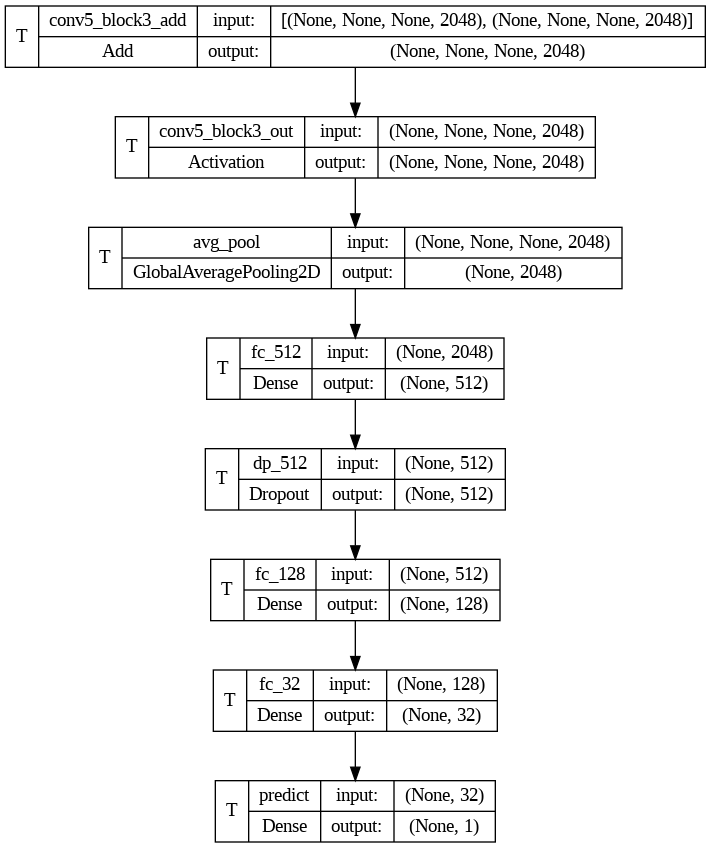

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/SK/best_model.h5')
model.trainable = True
tf.keras.utils.plot_model(model, show_shapes=True,layer_range=[model.layers[-8].name,model.layers[-1].name],show_trainable = True)

In [ ]:
import pickle
# training all layers (2nd stage), given the model saved on stage 1
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model (2nd stage) based on val_loss with a different name
mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/SK/best_model_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history
with open('/content/gdrive/MyDrive/temp/SK/train_history_2nd_stage.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/30
178/178 [==============================] - ETA: 0s - loss: 0.0188 - mae: 0.0880

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 76s 253ms/step - loss: 0.0188 - mae: 0.0880 - val_loss: 0.0155 - val_mae: 0.0740
Epoch 2/30
178/178 [==============================] - 46s 259ms/step - loss: 0.0129 - mae: 0.0666 - val_loss: 0.0140 - val_mae: 0.0687
Epoch 3/30
178/178 [==============================] - 47s 263ms/step - loss: 0.0103 - mae: 0.0557 - val_loss: 0.0130 - val_mae: 0.0659
Epoch 4/30
178/178 [==============================] - 47s 262ms/step - loss: 0.0088 - mae: 0.0479 - val_loss: 0.0123 - val_mae: 0.0649
Epoch 5/30
178/178 [==============================] - 36s 204ms/step - loss: 0.0080 - mae: 0.0449 - val_loss: 0.0124 - val_mae: 0.0656
Epoch 6/30
178/178 [==============================] - 51s 288ms/step - loss: 0.0076 - mae: 0.0437 - val_loss: 0.0118 - val_mae: 0.0639
Epoch 7/30
178/178 [==============================] - 52s 290ms/step - loss: 0.0074 - mae: 0.0434 - val_loss: 0.0115 - val_mae: 0.0639
Epoch 8/30
178/178 [==============================] - 49s 277ms/st

Custom weights

In [ ]:
# counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      g1 +=1
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      g2 +=1
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      g3 +=1
    if(Y_train[i]*100>=60):
      g4 +=1
print('group(s) size = ', [g1, g2, g3, g4])

# generating the weights for each group using the equation defined above
w = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
print('weights per group = ', w)

# creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights = []
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      sample_weights.append(w[0])
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      sample_weights.append(w[1])
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      sample_weights.append(w[2])
    if(Y_train[i]*100>=60):
      sample_weights.append(w[3])
sample_weights = np.array(sample_weights)

group(s) size =  [534, 1683, 525, 103]
weights per group =  [1.33192884 0.42260844 1.3547619  6.90533981]


In [ ]:
RESUME_TRAINING = False
RESUME_FROM_EPOCH = 9
NUM_EPOCHS = 30
import pickle
# loading the saved model (best model learned at stage 1)
if(RESUME_TRAINING == False):
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/SK/best_model.h5') # load model from stage 1
else:
  # resume training (stage 2)
  model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/SK/best_model_2nd_stage_weighted.h5')

# setting all layers to traineble
model.trainable = True

#=================================================
# training all layers (2nd stage), given the model saved on stage 1
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
#=================================================

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/SK/best_model_2nd_stage_weighted.h5', monitor='val_loss', mode='min', save_best_only=True)

if(RESUME_TRAINING == False):
  history = model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
  # saving training history
  with open('/content/gdrive/MyDrive/temp/SK/train_history_2nd_stage_weighted.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
  history = model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=RESUME_FROM_EPOCH, shuffle=True, verbose=1, callbacks=[es,mc])
  # in this code, the training history is not saved if you resume training

Epoch 1/30
178/178 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.0982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 88s 260ms/step - loss: 0.0315 - mae: 0.0982 - val_loss: 0.0197 - val_mae: 0.0890
Epoch 2/30
178/178 [==============================] - 46s 258ms/step - loss: 0.0206 - mae: 0.0749 - val_loss: 0.0160 - val_mae: 0.0732
Epoch 3/30
178/178 [==============================] - 46s 259ms/step - loss: 0.0164 - mae: 0.0650 - val_loss: 0.0156 - val_mae: 0.0703
Epoch 4/30
178/178 [==============================] - 51s 289ms/step - loss: 0.0134 - mae: 0.0577 - val_loss: 0.0146 - val_mae: 0.0675
Epoch 5/30
178/178 [==============================] - 47s 264ms/step - loss: 0.0114 - mae: 0.0527 - val_loss: 0.0139 - val_mae: 0.0648
Epoch 6/30
178/178 [==============================] - 37s 209ms/step - loss: 0.0107 - mae: 0.0513 - val_loss: 0.0163 - val_mae: 0.0761
Epoch 7/30
178/178 [==============================] - 60s 335ms/step - loss: 0.0092 - mae: 0.0464 - val_loss: 0.0128 - val_mae: 0.0620
Epoch 8/30
178/178 [==============================] - 45s 251ms/st

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt
# aux variables
X_train_augmented = []
Y_train_augmented = []

# loading the train data and labels
print('Train set before augmentation = ', np.array(X_train).shape)

# augmenting the data
for i in range(0,len(X_train)):
  # check if image is in the group 'age >= 60'

  if Y_train[i]*100>=60: # here labels are multiplied by 100 as they were normalized to be between [0,1]
    # flip
    X_train_augmented.append(cv2.flip(X_train[i], 1))
    Y_train_augmented.append(Y_train[i])

    # changing brightness
    x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
    Y_train_augmented.append(Y_train[i])

    # blur
    X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
    Y_train_augmented.append(Y_train[i])

    # translation
    rows, cols ,c= X_train[i].shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    X_train_augmented.append(cv2.warpAffine(X_train[i], M, (cols, rows)))
    Y_train_augmented.append(Y_train[i])

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)
del X_train_augmented, Y_train_augmented


#=================================================================
# post-processing the train data with respect to ResNet-50 Inputs.
#=================================================================
# train set
X_train = X_train.astype('float32')
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

Train set before augmentation =  (2845, 224, 224, 3)
Train set after augmentation =  (3257, 224, 224, 3)


(3257, 224, 224, 3)


In [ ]:
import pickle
# loading the saved model (best model learned at stage 1)
saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/SK/best_model.h5')

# setting all layers to traineble
saved_model.trainable = True

# training all layers (2nd stage), given the model saved on stage 1
saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# saving the best model (2nd stage) based on val_loss with a different name
mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/SK/best_model_2nd_stage_augmentation.h5', monitor='val_loss', mode='min', save_best_only=True)

history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=30, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history
with open('/content/gdrive/MyDrive/temp/SK/train_history_2nd_stage_augmentation.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/30
204/204 [==============================] - ETA: 0s - loss: 0.0232 - mae: 0.1035

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


204/204 [==============================] - 101s 257ms/step - loss: 0.0232 - mae: 0.1035 - val_loss: 0.0170 - val_mae: 0.0804
Epoch 2/30
204/204 [==============================] - 58s 286ms/step - loss: 0.0157 - mae: 0.0771 - val_loss: 0.0165 - val_mae: 0.0810
Epoch 3/30
204/204 [==============================] - 59s 288ms/step - loss: 0.0129 - mae: 0.0643 - val_loss: 0.0165 - val_mae: 0.0803
Epoch 4/30
204/204 [==============================] - 68s 332ms/step - loss: 0.0107 - mae: 0.0544 - val_loss: 0.0158 - val_mae: 0.0772
Epoch 5/30
204/204 [==============================] - 49s 238ms/step - loss: 0.0092 - mae: 0.0462 - val_loss: 0.0161 - val_mae: 0.0812
Epoch 6/30
204/204 [==============================] - 68s 335ms/step - loss: 0.0090 - mae: 0.0468 - val_loss: 0.0144 - val_mae: 0.0730
Epoch 7/30
204/204 [==============================] - 49s 239ms/step - loss: 0.0080 - mae: 0.0418 - val_loss: 0.0145 - val_mae: 0.0744
Epoch 8/30
204/204 [==============================] - 47s 232ms/s

Evaluate the four models in test

In [ ]:
import numpy as np
# loading the validation data (with labels)
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_test = Y_test/100

print('Train data size and shape', X_test.shape)
print('Train labels size and shape', Y_test.shape)
print('Train metadata size and shape', M_test.shape)

Train data size and shape (1978, 224, 224, 3)
Train labels size and shape (1978,)
Train metadata size and shape (1978, 3)


In [ ]:
#Preprocess:
import tensorflow as tf
X_test = X_test.astype('float32')
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf.keras.applications.resnet50.preprocess_input(x)
print(np.max(X_test))

151.061


In [ ]:
model_st2_weighted_sk = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/SK/best_model_2nd_stage_weighted.h5')
predictions_st2_weighted_sk = model_st2_weighted_sk.predict(X_test, batch_size=32, verbose=1)*100
# evaluating on validation data
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_st2_weighted_sk[i][0],Y_test[i]*100)))

print('MAE (test set - with custom loss) = %.8f' %(np.mean(error)))

import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

age_bias(predictions_st2_weighted_sk,Y_test*100)

gender_bias(predictions_st2_weighted_sk,Y_test*100,M_test)

ethnicity_bias(predictions_st2_weighted_sk,Y_test*100,M_test)

face_expression_bias(predictions_st2_weighted_sk,Y_test*100,M_test)

62/62 [==============================] - 6s 91ms/step
MAE (test set - with custom loss) = 6.37036684
Age analysis:
Size group 1 = 369, MAE = 6.207859
Size group 2 = 1044, MAE = 5.169761
Size group 3 = 390, MAE = 6.464298
Size group 4 = 175, MAE = 13.666169
---------
Age bias (Ba) =  4.2909440994262695
Gender analysis:
Size group female = 1020, MAE = 6.475224
Size group male = 958, MAE = 6.258723
---------
Gender bias (Bg) =  0.21650171
Ethnicity Analysis:
Size group asian = 129, MAE = 6.632680
Size group afroamerican = 56, MAE = 5.572327
Size group caucasian = 1793, MAE = 6.376420
---------
Ethnicity bias (Be) =  0.7069018681844076
Face experession Analysis:
Size group happy = 589, MAE = 6.294905
Size group slightlyhappy = 505, MAE = 6.379960
Size group neutral = 756, MAE = 6.337848
Size group other = 128, MAE = 6.871823
---------
Face Expression bias (Bf) =  0.2954779465993245


In [ ]:
model_st2_augmentation = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5')
predictions_st2_augmentation = model_st2_augmentation.predict(X_test, batch_size=32, verbose=1)*100
# evaluating on validation data
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_st2_augmentation[i][0],Y_test[i]*100)))

print('MAE (test set - with custom loss) = %.8f' %(np.mean(error)))

import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

age_bias(predictions_st2_augmentation,Y_test*100)

gender_bias(predictions_st2_augmentation,Y_test*100,M_test)

ethnicity_bias(predictions_st2_augmentation,Y_test*100,M_test)

face_expression_bias(predictions_st2_augmentation,Y_test*100,M_test)

62/62 [==============================] - 15s 240ms/step
MAE (test set - with custom loss) = 5.46721427
Age analysis:
Size group 1 = 369, MAE = 4.824574
Size group 2 = 1044, MAE = 4.058851
Size group 3 = 390, MAE = 6.868176
Size group 4 = 175, MAE = 12.102012
---------
Age bias (Ba) =  4.362180391947429
Gender analysis:
Size group female = 1020, MAE = 5.752707
Size group male = 958, MAE = 5.163245
---------
Gender bias (Bg) =  0.5894618
Ethnicity Analysis:
Size group asian = 129, MAE = 5.576425
Size group afroamerican = 56, MAE = 5.590501
Size group caucasian = 1793, MAE = 5.455506
---------
Ethnicity bias (Be) =  0.0899966557820638
Face experession Analysis:
Size group happy = 589, MAE = 5.548865
Size group slightlyhappy = 505, MAE = 5.524982
Size group neutral = 756, MAE = 5.434353
Size group other = 128, MAE = 5.057667
---------
Face Expression bias (Bf) =  0.26070388158162433


In [ ]:
model_st2_weighted = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')
predictions_st2_weighted = model_st2_weighted.predict(X_test, batch_size=32, verbose=1)*100
# evaluating on validation data
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_st2_weighted[i][0],Y_test[i]*100)))

print('MAE (test set - with custom loss) = %.8f' %(np.mean(error)))

import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

age_bias(predictions_st2_weighted,Y_test*100)

gender_bias(predictions_st2_weighted,Y_test*100,M_test)

ethnicity_bias(predictions_st2_weighted,Y_test*100,M_test)

face_expression_bias(predictions_st2_weighted,Y_test*100,M_test)

62/62 [==============================] - 23s 236ms/step
MAE (test set - with custom loss) = 5.75180524
Age analysis:
Size group 1 = 369, MAE = 5.131705
Size group 2 = 1044, MAE = 4.700918
Size group 3 = 390, MAE = 6.640099
Size group 4 = 175, MAE = 11.348997
---------
Age bias (Ba) =  3.5754384994506836
Gender analysis:
Size group female = 1020, MAE = 6.119143
Size group male = 958, MAE = 5.360693
---------
Gender bias (Bg) =  0.7584505
Ethnicity Analysis:
Size group asian = 129, MAE = 5.651967
Size group afroamerican = 56, MAE = 5.304400
Size group caucasian = 1793, MAE = 5.772962
---------
Ethnicity bias (Be) =  0.312374750773112
Face experession Analysis:
Size group happy = 589, MAE = 5.809022
Size group slightlyhappy = 505, MAE = 5.993824
Size group neutral = 756, MAE = 5.621695
Size group other = 128, MAE = 5.302143
---------
Face Expression bias (Bf) =  0.37706200281778973


In [ ]:
import csv
predictions_st2_test = model_st2_weighted.predict(X_test, batch_size=32, verbose=1)*100
# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_test)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions_st2_weighted.zip predictions.csv

In [ ]:
model_st2_augmentation_sk = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/SK/best_model_2nd_stage_augmentation.h5')
predictions_st2_augmentation_sk = model_st2_augmentation_sk.predict(X_test, batch_size=32, verbose=1)*100
# evaluating on validation data
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_st2_augmentation_sk[i][0],Y_test[i]*100)))

print('MAE (test set - with custom loss) = %.8f' %(np.mean(error)))

import os
if not os.path.exists('/content/gdrive/MyDrive/temp/bias_functions.py'):
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

age_bias(predictions_st2_augmentation_sk,Y_test*100)

gender_bias(predictions_st2_augmentation_sk,Y_test*100,M_test)

ethnicity_bias(predictions_st2_augmentation_sk,Y_test*100,M_test)

face_expression_bias(predictions_st2_augmentation_sk,Y_test*100,M_test)

62/62 [==============================] - 7s 92ms/step
MAE (test set - with custom loss) = 6.69713452
Age analysis:
Size group 1 = 369, MAE = 6.521524
Size group 2 = 1044, MAE = 4.553939
Size group 3 = 390, MAE = 8.653210
Size group 4 = 175, MAE = 15.493856
---------
Age bias (Ba) =  5.825239181518555
Gender analysis:
Size group female = 1020, MAE = 6.809175
Size group male = 958, MAE = 6.577843
---------
Gender bias (Bg) =  0.2313323
Ethnicity Analysis:
Size group asian = 129, MAE = 6.802289
Size group afroamerican = 56, MAE = 5.877671
Size group caucasian = 1793, MAE = 6.715163
---------
Ethnicity bias (Be) =  0.6164121627807617
Face experession Analysis:
Size group happy = 589, MAE = 6.708252
Size group slightlyhappy = 505, MAE = 6.530599
Size group neutral = 756, MAE = 6.724606
Size group other = 128, MAE = 7.140761
---------
Face Expression bias (Bf) =  0.30780673027038574
